In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import sys

from theano import tensor as tt
import theano as th
from lasagne.updates import adam, adadelta, sgd

sys.path.append('../')
from meanfield.meanfield import *
from meanfield.layers.input import *
from meanfield.layers.dense import *
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import make_moons

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: GeForce GTX 460 (0000:03:00.0)


In [2]:
Network.sample_size = 20
Network.target_std_deviation = 0.1 #this feature doesn't affect anything in case of classification
Dense.initial_sigma = -4 #the initial std deviation of weights will be e^-5. 
                        #Higher initial deviation leads to unability to train big networks?

In [3]:
X, y = make_moons(n_samples=1000, noise=0.2)

In [4]:
stdx = StandardScaler()
X = stdx.fit(X).transform(X)

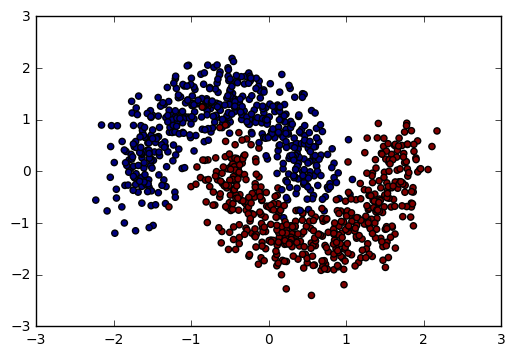

In [5]:
cmap = y
plt.scatter(x=X[:,0],y=X[:,1], c=cmap)
plt.show()

In [6]:
y = OneHotEncoder().fit(y.reshape((-1,1))).transform(y.reshape((-1,1))).toarray()

In [7]:
X, y = np.array(X), np.array(y)

In [8]:
X.shape, y.shape

((1000, 2), (1000, 2))

In [9]:
inp = Input(2)

d1 = Dense(200, inp, prior=150)
d2 = Dense(200, d1, prior=160)
d3 = Dense(30, d2, prior=160)

out = Dense(2, d3, act=lambda x: tt.clip(tt.nnet.softmax(x), 1e-7, 1.0 - 1e-7), prior=200)

Reshape{3}.0
Reshape{3}.0
Reshape{3}.0
Reshape{3}.0


In [10]:
lr = th.shared(np.array(0.001, dtype='float32'))

In [11]:
model = Model(input=inp, output=out, loss='crossentropy', 
              init_value_loss_repar=1.6, nnupdates=lambda x, y: adam(x, y, lr))

In [12]:
for _ in range(760):
    model.fit(X=X, y=y, batchsize=100, nepoch=80, log_freq=80, shuffle_freq=40)
    if _ % 10 == 0:
        print(d1.sigma.eval())

epoch: 0 
  train error: 0.5 
  objective: 7938.50159094603
  loss_scale: 0.9308615922927856


[[ 0.0357266   0.03571277  0.02029261  0.03179811  0.02841546  0.0167311
   0.0303086   0.02723897  0.01772473  0.01992656  0.01609176  0.03627277
   0.0389472   0.03469278  0.03703671  0.03522283  0.02672502  0.03128379
   0.03116879  0.02700272  0.02982175  0.03822717  0.02193958  0.02936204
   0.02815399  0.03934199  0.02016504  0.02692343  0.02680665  0.02757849
   0.02349936  0.02799409  0.02500151  0.02832446  0.03546133  0.03449109
   0.03751772  0.03510256  0.02670832  0.03777277  0.0305694   0.03411653
   0.02708958  0.03333212  0.02915664  0.02542328  0.03820791  0.03499395
   0.0319336   0.02273487  0.03206475  0.03390351  0.01503762  0.02602393
   0.02771903  0.02700709  0.03860176  0.03816867  0.02575029  0.02925511
   0.02956105  0.02459429  0.03788164  0.02716484  0.03350475  0.02040399
   0.02800259  0.01849891  0.03760524  0.03327391  0.0361101   0.03810572
   0.02728105  0.0

KeyboardInterrupt: 

In [13]:
samplesize = 1

In [14]:
base = np.linspace(start=-8, stop=8, num=100, dtype='float32')
X_test = np.array([[x,y] for x in base for y in base])
y_pred = model.predict(X_test, prediction_sample_size=samplesize, return_distrib=False, batchsize=3)

100%|█████████▉| 99.9999999999931/100 [01:40<00:00,  1.00s/it] 


In [15]:
pr = y_pred[:,0].reshape((100,100))

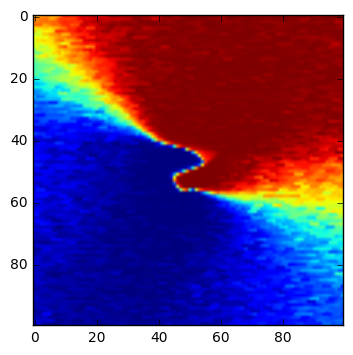

In [16]:
plt.imshow(pr)
plt.show()

100%|█████████▉| 99.9999999999931/100 [00:15<00:00,  6.37it/s] 


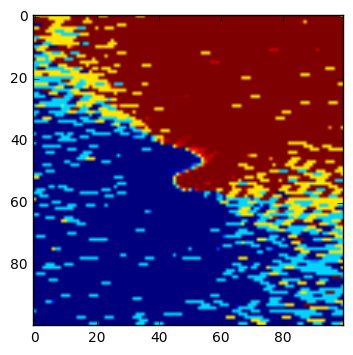

In [19]:
samplesize = 3
base = np.linspace(start=-8, stop=8, num=100, dtype='float32')
X_test = np.array([[x,y] for x in base for y in base])
y_pred = model.predict(X_test, prediction_sample_size=samplesize, return_distrib=False, batchsize=3)
pr = y_pred[:,0].reshape((100,100))
plt.imshow(pr)
plt.show()